# Worksheet 13

Name: Yiran Huang
UID: U71885452

### Topics

- Support Vector Machines

## Support Vector Machines

a) Follow along in class to implement the perceptron algorithm and create an animation of the algorithm.

In [1]:
import numpy as np
from PIL import Image as im
import matplotlib.pyplot as plt
import sklearn.datasets as datasets

TEMPFILE = "temp.png"
CENTERS = [[0, 1], [1, 0]]

# Dataset
X, labels = datasets.make_blobs(n_samples=10, centers=CENTERS, cluster_std=0.2, random_state=0)
Y = np.array(list(map(lambda x : -1 if x == 0 else 1, labels.tolist())))

# Initializing w and b
w = np.array([1, 1])
b = 0.1

# Perceptron Parameters
epochs = 100
alpha = .05
expanding_rate = .99
retracting_rate = 1.1

def snap(x, w, b, error):
    """
        Plot the street induced by w and b.
        Circle the point x in red if it was
        misclassified or in yellow if it was
        classified correctly.
    """

    xplot = np.linspace(-3, 3)
    cs = np.array([x for x in 'gb'])

    svm = - w[0] * xplot / w[1] - b / w[1]
    left_svm = - w[0] * xplot / w[1] - b / w[1] - 1 / w[1]
    right_svm = - w[0] * xplot / w[1] - b / w[1] + 1 / w[1]

    fig, ax = plt.subplots()
    ax.scatter(X[:,0],X[:,1],color=cs[labels].tolist(), s=50, alpha=0.8)
    if error:
        ax.add_patch(plt.Circle((x[0], x[1]), .2, color='r',fill=False))
    else:
        ax.add_patch(plt.Circle((x[0], x[1]), .2, color='y',fill=False))
    ax.plot(xplot, left_svm, 'g--', lw=2)
    ax.plot(xplot, svm, 'r-', lw=2)
    ax.plot(xplot, right_svm, 'b--', lw=2)
    ax.set_xlim(min(X[:, 0]) - 1, max(X[:,0]) + 1)
    ax.set_ylim(min(X[:, 1]) - 1, max(X[:,1]) + 1)
    fig.savefig(TEMPFILE)
    plt.close()

    return im.fromarray(np.asarray(im.open(TEMPFILE)))


images = []
for _ in range(epochs):
    # pick a point from X at random
    i = np.random.randint(0, len(X))
    x, y = X[i], Y[i]
    error = False

    y_pred = np.dot(w, x) + b
    if np.sign(y_pred) == np.sign(y):
        if y_pred > -1 and y_pred < 1:
            w = w + y * alpha * x * retracting_rate
            b = b + y * alpha * retracting_rate
        else:
            w = w * expanding_rate
            b = b * expanding_rate
    else:
        w = w + y * alpha * x * expanding_rate
        b = b + y * alpha * expanding_rate
                    
    images.append(snap(x, w, b, error))

images[0].save(
    'svm.gif',
    optimize=False,
    save_all=True,
    append_images=images[1:],
    loop=0,
    duration=100
)

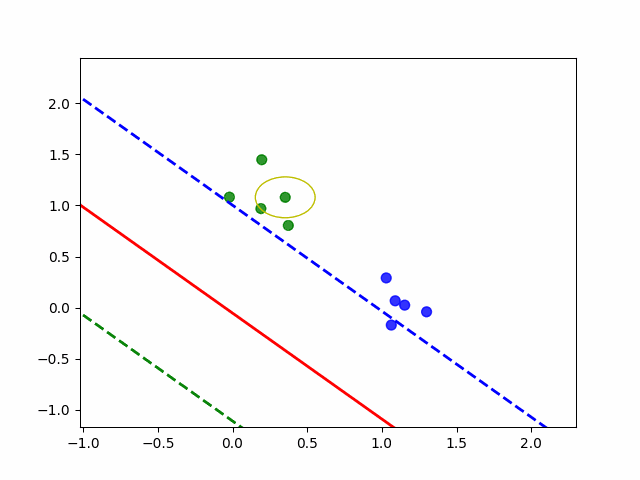

In [1]:
from IPython.display import Image
Image(filename="svm.gif", width=500, height=500)

b) Consider the following dataset:

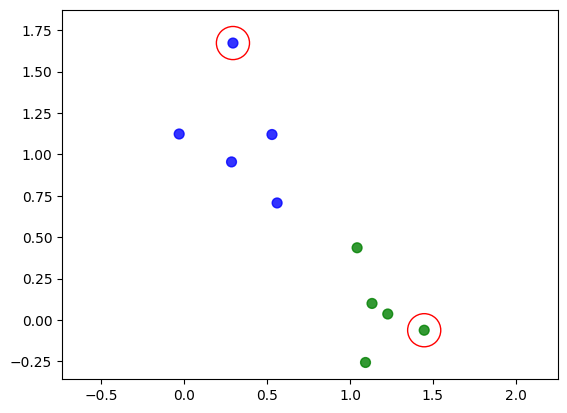

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets as datasets

centers = [[0, 1], [1, 0]]
X, _ = datasets.make_blobs(n_samples=10, centers=centers, cluster_std=0.3, random_state=0)
Y = np.array([1 if x[0] - x[1] >= 0 else 0 for x in X])

cs = np.array([x for x in 'bg'])
_, ax = plt.subplots()
ax.scatter(X[:,0],X[:,1],color=cs[Y].tolist(), s=50, alpha=0.8)
ax.set_aspect('equal', adjustable='datalim')
ax.add_patch(plt.Circle((X[0][0], X[0][1]), .1, color='r',fill=False))
ax.add_patch(plt.Circle((X[1][0], X[1][1]), .1, color='r',fill=False))
plt.show()

if we fit an SVM to the above dataset, moved the points circled in red, and re-fit the SVM, describe how the fit would change depending on how the points are moved.

if moving the points circled in red beyond the closest point then they can affect the boundary.

c) If we were to fit an SVM to the above dataset, which points do you think would affect the decision boundary the most? Circle them in red.

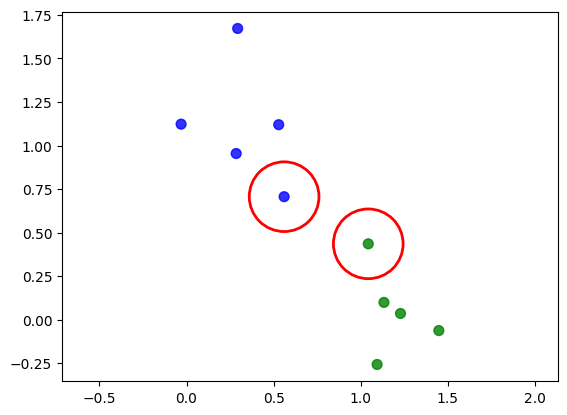

In [2]:
cs = np.array([x for x in 'bg'])
_, ax = plt.subplots()
ax.scatter(X[:,0],X[:,1],color=cs[Y].tolist(), s=50, alpha=0.8)
ax.set_aspect('equal', adjustable='datalim')

ax.add_patch(plt.Circle((X[2][0], X[2][1]), .2, color='r', fill=False, lw=2))
ax.add_patch(plt.Circle((X[6][0], X[6][1]), .2, color='r', fill=False, lw=2))

plt.show()

d) As we saw in class, the form
$$w^T x + b = 0$$
while simple, does not expose the inner product `<x_i, x_j>` which we know `w` depends on, having done the math. This is critical to applying the "kernel trick" which allows for learning non-linear decision boundaries. Let's modify the above algorithm to use the form
$$\sum_i \alpha_i <x_i, x> + b = 0$$

In [7]:
import numpy as np
from PIL import Image as im
import matplotlib.pyplot as plt
import sklearn.datasets as datasets

TEMPFILE = "temp.png"
CENTERS = [[0, 1], [1, 0]]

epochs = 100
learning_rate = .05
expanding_rate = .99
retracting_rate = 1.1

X, labels = datasets.make_blobs(n_samples=10, centers=CENTERS, cluster_std=0.2, random_state=0)
Y = np.array(list(map(lambda x : -1 if x == 0 else 1, labels.tolist())))

alpha_i = np.zeros((len(X),))
b = 0

def snap(x, alpha_i, b, error):
    # create a mesh to plot in
    h = .01  # step size in the mesh
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    meshData = np.c_[xx.ravel(), yy.ravel()]
    cs = np.array([x for x in 'gb'])
    fig, ax = plt.subplots()
    ax.scatter(X[:,0],X[:,1],color=cs[labels].tolist(), s=50, alpha=0.8)

    if error:
        ax.add_patch(plt.Circle((x[0], x[1]), .12, color='r',fill=False))
    else:
        ax.add_patch(plt.Circle((x[0], x[1]), .12, color='y',fill=False))
   
    Z = predict_many(alpha_i, b, meshData)
    Z = np.array([0 if z <=0 else 1 for z in Z]).reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=.5, cmap=plt.cm.Paired)
    fig.savefig(TEMPFILE)
    plt.close()
    return im.fromarray(np.asarray(im.open(TEMPFILE)))

def predict_many(alpha_i, b, Z):
    res = []
    for i in range(len(Z)):
        res.append(predict(alpha_i, b, Z[i]))
    return np.array(res)

def predict(alpha_i, b, x):
    prediction = b
    for i in range(len(X)):
        prediction += alpha_i[i] * np.dot(X[i], x)
    return prediction

images = []
for _ in range(epochs):
    # pick a point from X at random
    i = np.random.randint(0, len(X))
    error = False
    x, y = X[i], Y[i]
    
    prediction = predict(alpha_i, b, x)
    if y*prediction <= 0:
        alpha_i[i] += learning_rate * y
        b += learning_rate * y
        error = True
        
    images.append(snap(x, alpha_i, b, error))

images[0].save(
    'svm_dual.gif',
    optimize=False,
    save_all=True,
    append_images=images[1:],
    loop=0,
    duration=100
)

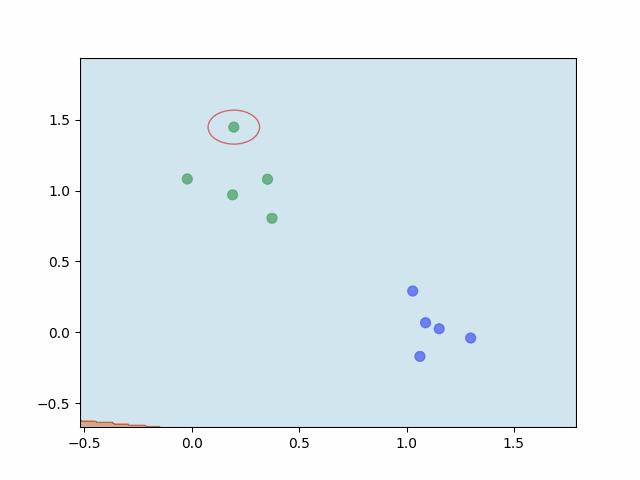

In [1]:
from IPython.display import Image
Image(filename="svm_dual.gif", width=500, height=500)

Write a configurable kernel function to apply in lieu of the dot product. Try it out on a dataset that is not linearly separable.

In [1]:
def polynomial(x_i, x_j, c, n):
    return (np.dot(x_i, x_j) + c) ** n

def polynomial_kernel(X, Y, c=1, n=2):
    K = (np.dot(X, Y.T) + c) ** n
    return K

def predict(alpha_i, b, x, X, Y, kernel_fn, **kwargs):
    K = kernel_fn(X, np.array([x]), **kwargs)
    y_pred = np.dot(alpha_i * Y, K) + b
    return np.sign(y_pred).item()

def predict_many(alpha_i, b, Z, X, Y, kernel_fn, **kwargs):
    K = kernel_fn(X, Z, **kwargs)
    y_pred = np.dot(alpha_i * Y, K) + b
    return np.sign(y_pred)

e) Assume we fit an SVM using a polynomial Kernel function and it seems to overfit the data. How would you adjust the tuning parameter `n` of the kernel function?

one way to adjust the tuning parameter n is to reduce its value. A lower value of n will result in a smoother decision boundary, which may help to reduce overfitting.

f) Assume we fit an SVM using a RBF Kernel function and it seems to underfit the data. How would you adjust the tuning parameter `sigma` of the kernel function?

If the SVM is underfitting the data, one way to adjust the tuning parameter sigma is to increase its value. A higher value of sigma will result in a more flexible decision boundary, which may help to reduce underfitting.

g) Tune the parameter of a specific Kernel function, to fit an SVM (using your code above) to the following dataset:

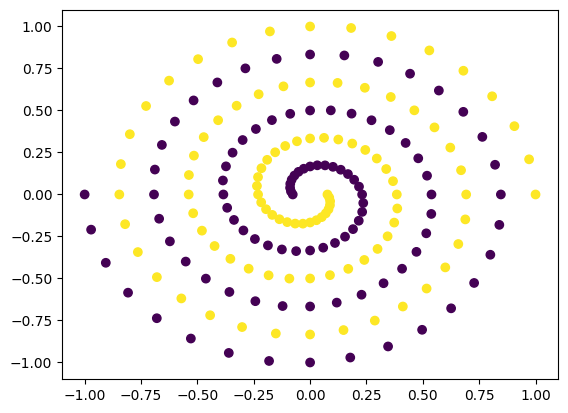

In [1]:
import numpy as np
import matplotlib.pyplot as plt

data = np.loadtxt("spiral.data")
x, y = data[:, :2], data[:, 2]

plt.scatter(x[:,0], x[:,1], c=y)